Importowanie pakietów

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import chi2_contingency
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

**Zadanie a - Topsis**

Wczytanie danych

In [3]:
df = pd.read_excel(r"Data\Dane.xlsx", sheet_name="Dane")
zmienne_df = pd.read_excel(r"Data\Dane.xlsx", sheet_name="Zmienne")

In [4]:
cechy = [f'X{i}' for i in range(1, 13)]
data = df[cechy].values
wojewodztwa = df['Nazwa'].values

Normalizacja

In [5]:
m, n = data.shape
norm_data = np.zeros((m, n))

for j in range(n):
    norm = np.sqrt(np.sum(data[:, j]**2))
    norm_data[:, j] = data[:, j] / norm

Wagi

In [6]:
wagi = np.ones(n) / n
weighted_data = norm_data * wagi

Wzorzec i antywzrorzec

In [7]:
A_plus = np.max(weighted_data, axis=0)
A_minus = np.min(weighted_data, axis=0)

Odległości Euklidesowe

In [8]:
D_plus = np.sqrt(np.sum((weighted_data - A_plus)**2, axis=1))
D_minus = np.sqrt(np.sum((weighted_data - A_minus)**2, axis=1))

Współczynnik R

In [9]:
R = D_minus / (D_plus + D_minus)

In [10]:
df['R'] = R
df_rank = df.sort_values(by='R', ascending=False).reset_index(drop=True)

Wyniki Topsis

In [11]:
print("Ranking województw metodą TOPSIS (2021):")
print(df_rank[['Nazwa', 'R']])

Ranking województw metodą TOPSIS (2021):
                  Nazwa         R
0           mazowieckie  0.777126
1          dolnośląskie  0.562112
2               śląskie  0.531213
3         wielkopolskie  0.517304
4           małopolskie  0.485140
5             pomorskie  0.428014
6               łódzkie  0.368750
7    zachodniopomorskie  0.330535
8          podkarpackie  0.321454
9              lubuskie  0.315902
10   kujawsko-pomorskie  0.273827
11             opolskie  0.260236
12       świętokrzyskie  0.226971
13            podlaskie  0.174501
14            lubelskie  0.164320
15  warmińsko-mazurskie  0.146441


Wykres

C:\Users\dudek\AppData\Local\Temp\ipykernel_26696\3383949964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R', y='Nazwa', data=df_rank, palette='Blues_r')


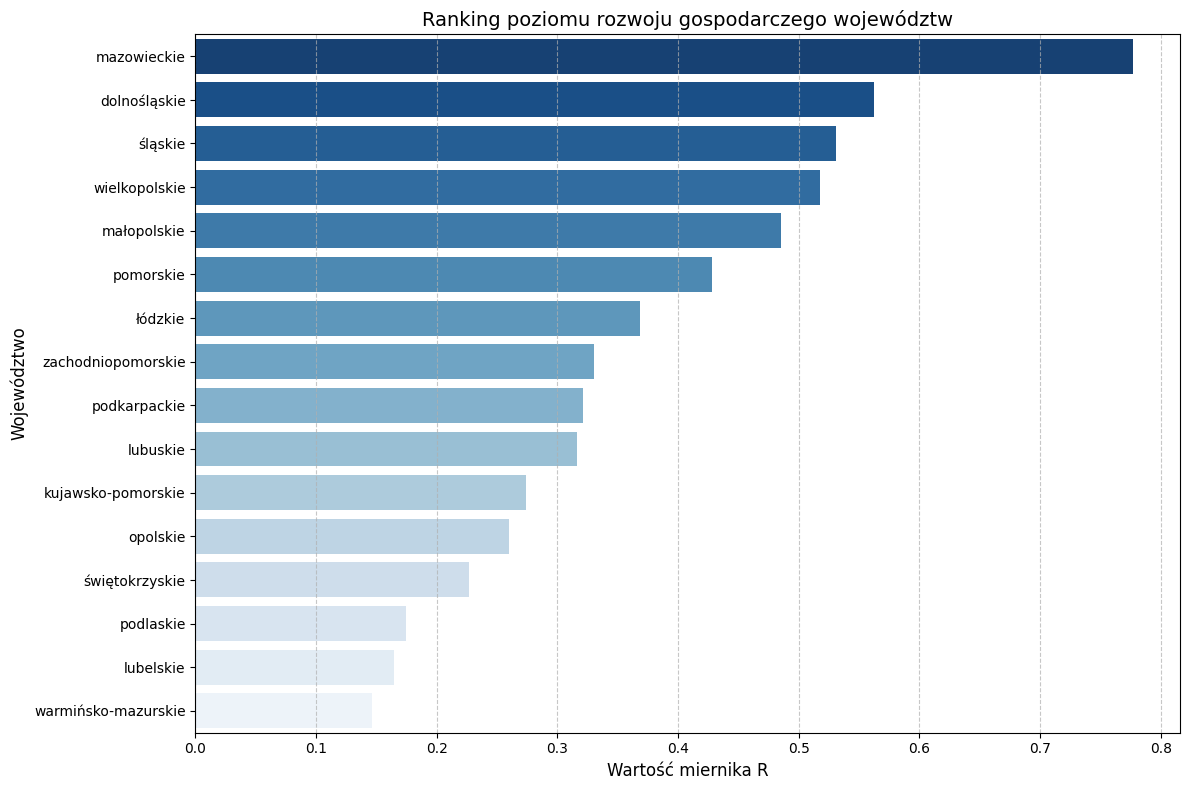

In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x='R', y='Nazwa', data=df_rank, palette='Blues_r')
plt.title('Ranking poziomu rozwoju gospodarczego województw', fontsize=14)
plt.xlabel('Wartość miernika R', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('topsis_ranking.png')
plt.show()

Kartogram

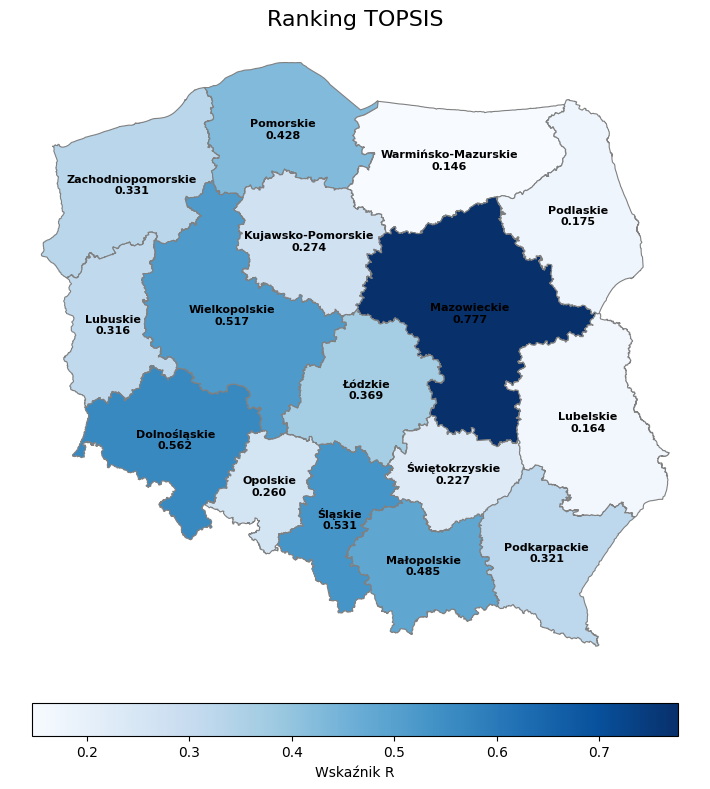

In [13]:
wojewodztwa = gpd.read_file(r"Data\Wojewodztwa\wojewodztwa.shp")

wojewodztwa['klucz'] = wojewodztwa['JPT_NAZWA_'].astype(str).str.lower()
df['klucz'] = df['Nazwa'].astype(str).str.lower()

merged = wojewodztwa.merge(df, left_on='klucz', right_on='klucz')

fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

merged.plot(column='R', ax=ax, legend=True, cmap='Blues', 
            edgecolor='gray', linewidth=0.8,
            legend_kwds={'label': "Wskaźnik R", 'orientation': "horizontal", 'fraction': 0.046, 'pad': 0.04})

for idx, row in merged.iterrows():
    xy = row.geometry.centroid.coords[0]
    tekst = f"{row['Nazwa'].title()}\n{row['R']:.3f}"
    ax.annotate(text=tekst, xy=xy, xytext=(0, 0), textcoords="offset points",
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, fontweight='bold', color='black') 

plt.axis('off')
plt.title('Ranking TOPSIS', fontsize=16)
plt.tight_layout()
plt.savefig('topsis_mapa.png')
plt.show()

**Zadanie b - wskaźnik wynagrodzenie**

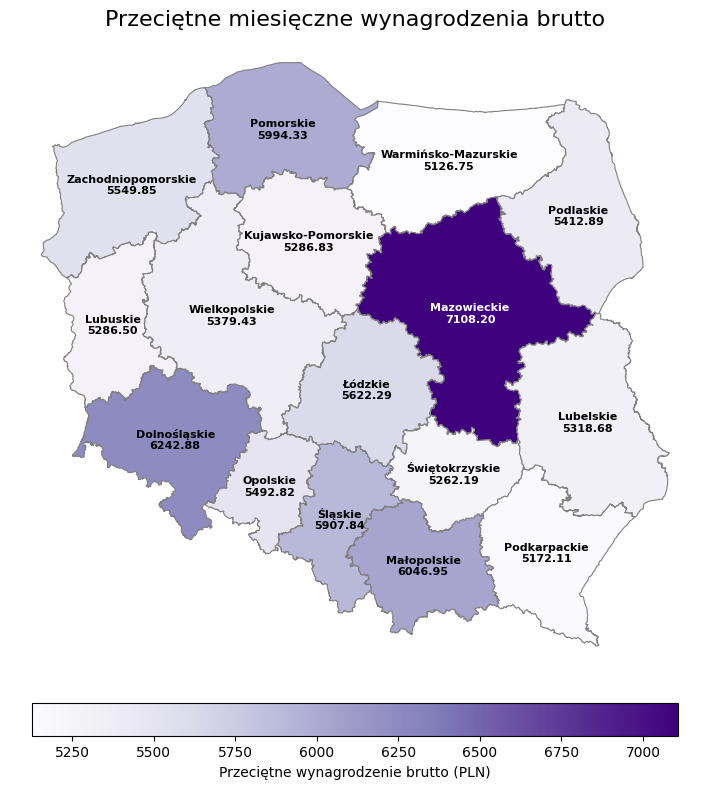

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

merged.plot(column='X2', ax=ax, legend=True, cmap='Purples', 
            edgecolor='gray', linewidth=0.8,
            legend_kwds={'label': "Przeciętne wynagrodzenie brutto (PLN)", 
                         'orientation': "horizontal", 
                         'fraction': 0.046, 'pad': 0.04})

max_idx = merged['X2'].idxmax()

for idx, row in merged.iterrows():
    xy = row.geometry.centroid.coords[0]
    tekst = f"{row['Nazwa'].title()}\n{row['X2']:.2f}"
    max_idx_tekst = 'white' if idx == max_idx else 'black'
    ax.annotate(text=tekst, xy=xy, xytext=(0, 0), textcoords="offset points",
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, fontweight='bold', color=max_idx_tekst) 
    
plt.axis('off')
plt.title('Przeciętne miesięczne wynagrodzenia brutto', fontsize=16)
plt.tight_layout()
plt.savefig('mapa_wynagrodzenia.png')
plt.show()

**Zadanie d - analiza koszykowa**

In [147]:
df2 = pd.read_csv("Data/Dane.csv", sep=";", encoding="windows-1250")

Usuwanie polskich znaków

In [148]:
def delete_pl(text):
    if isinstance(text, str):
        polskie = "ącwęłńóśźżĄĆĘŁŃÓŚŹŻ"
        lacinskie = "acwelnoszzACELNOSZZ"
        trans_table = str.maketrans(polskie, lacinskie)
        return text.translate(trans_table)
    return text

df2['Produkt'] = df2['Produkt'].apply(delete_pl)

In [149]:
df2.head()

,Transakcja,Produkt
0,0,sledz
1,0,kukurydza
2,0,oliwki
3,0,szynka
4,0,indyk


In [150]:
transakcje = df2.groupby('Transakcja')['Produkt'].apply(list).tolist()

In [151]:
te = TransactionEncoder()
te_ary = te.fit(transakcje).transform(transakcje)

In [152]:
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [153]:
item_freq = df_encoded.sum().sort_values(ascending=False)

Popularne produkty

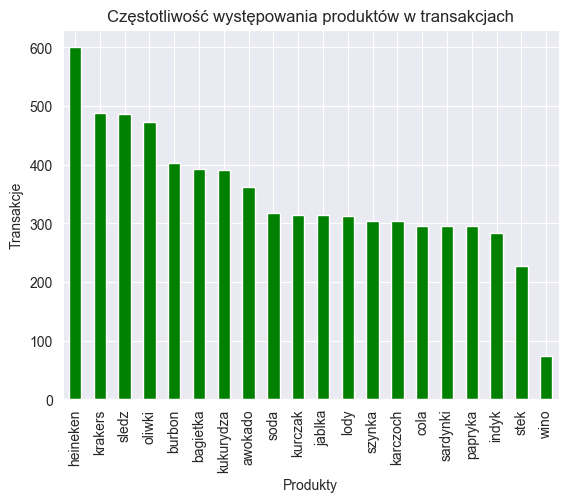

In [155]:
item_freq.plot(kind="bar", color="green", edgecolor="white")
plt.xlabel('Produkty')
plt.ylabel('Transakcje')
plt.title('Częstotliwość występowania produktów w transakcjach')
plt.savefig('czestotliwosc.png')
plt.show()

Parametry

In [139]:
frequent_itemset = apriori(df_encoded, min_support=0.15, use_colnames=True)

In [140]:
rules = association_rules(frequent_itemset, metric="confidence",
                          min_threshold=0.75).sort_values("confidence", ascending=False)

In [141]:
top_lift = rules.sort_values('lift', ascending=False).head(5)
print(top_lift)

             antecedents  consequents  antecedent support  consequent support  \
6    (awokado, heineken)   (karczoch)            0.248751            0.304695   
7   (karczoch, heineken)    (awokado)            0.251748            0.362637   
15       (sledz, oliwki)  (kukurydza)            0.255744            0.390609   
12      (soda, heineken)    (krakers)            0.256743            0.487512   
14   (kukurydza, oliwki)      (sledz)            0.236763            0.485514   

     support  confidence      lift  representativity  leverage  conviction  \
6   0.198801    0.799197  2.622938               1.0  0.123008    3.462617   
7   0.198801    0.789683  2.177609               1.0  0.107508    3.030479   
15  0.201798    0.789062  2.020081               1.0  0.101902    2.888963   
12  0.233766    0.910506  1.867656               1.0  0.108601    5.726491   
14  0.201798    0.852321  1.755500               1.0  0.086846    3.483802   

    zhangs_metric   jaccard  certainty  kulc

In [142]:
top_conf = rules.sort_values('confidence', ascending=False).head(5)
print(top_conf)

            antecedents consequents  antecedent support  consequent support  \
5   (awokado, karczoch)  (heineken)            0.210789            0.599401   
11      (krakers, soda)  (heineken)            0.250749            0.599401   
12     (soda, heineken)   (krakers)            0.256743            0.487512   
8     (bagietka, sledz)  (heineken)            0.248751            0.599401   
14  (kukurydza, oliwki)     (sledz)            0.236763            0.485514   

     support  confidence      lift  representativity  leverage  conviction  \
5   0.198801    0.943128  1.573452               1.0  0.072454    7.043873   
11  0.233766    0.932271  1.555339               1.0  0.083467    5.914732   
12  0.233766    0.910506  1.867656               1.0  0.108601    5.726491   
8   0.213786    0.859438  1.433829               1.0  0.064685    2.849979   
14  0.201798    0.852321  1.755500               1.0  0.086846    3.483802   

    zhangs_metric   jaccard  certainty  kulczynski  
5  

In [ ]:
rules.to_excel("z_d.xlsx")

Wykres punktowy

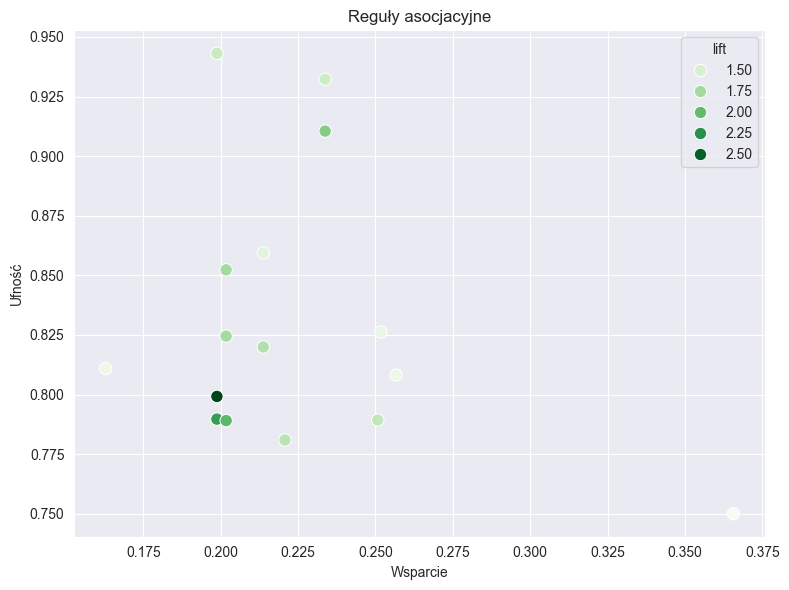

In [146]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=rules,
    x="support",
    y="confidence",
    hue=rules["lift"],
    palette="Greens",
    s=80
)

ax.set_xlabel("Wsparcie")
ax.set_ylabel("Ufność")
ax.set_title("Reguły asocjacyjne")

plt.tight_layout()
plt.savefig('reguly_asocjacyjne.png')
plt.show()

Zależność: soda, heineken -> krakers

| Support | Confidence | Lift |
| :--- | :--- | :--- |
| 0.233766 | 0.910506 | 1.867656 |

Interpretacja:
- Wsparcie (Support): Według tych wyników możemy zauważyć że 23% transakcji zawiera sodę, heinekena oraz krakersy.
- Ufność (Confidence): 9 na 10 osób kupujących sodę oraz heinekena, kupowało również krakersy.
- Lift: Mając w koszyku sodę oraz heinekena, klienci byli 1,87 razy bardziej skłonni do zakupu krakersów
